<a href="https://colab.research.google.com/github/Dulaj715/Srilanka-e-voting-system/blob/main/CRM_Stock_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
ticker = "CRM"
data = yf.download(ticker, period="5y")

data.head()

/tmp/ipython-input-748876640.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="5y")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,CRM,CRM,CRM,CRM,CRM
Date,,,,,
2021-02-22,238.057556,241.584708,237.494406,241.327819,5055000
2021-02-23,232.811279,236.091432,226.260864,232.435836,8641600
2021-02-24,237.583328,238.600963,228.730880,232.702627,6128300
2021-02-25,228.306030,237.464754,227.011758,235.666595,8828900
2021-02-26,213.901031,227.732969,213.742949,226.636293,20372900


In [ ]:
# Reset index to have Date as a column
data = data.reset_index()

# Flatten MultiIndex columns to single level
# yfinance columns typically have ('Metric', 'Ticker') or ('Date', '') after reset_index
new_columns = []
for col_tuple in data.columns:
    if isinstance(col_tuple, tuple):
        # For columns like ('Date', '')
        if col_tuple[1] == '':
            new_columns.append(col_tuple[0])
        # For columns like ('Close', 'CRM')
        else:
            new_columns.append(f"{col_tuple[0]}_{col_tuple[1]}")
    else: # Fallback, though yf.download columns are typically MultiIndex
        new_columns.append(col_tuple)
data.columns = new_columns

# Convert Date to datetime (now 'Date' is a single-level string)
data['Date'] = pd.to_datetime(data['Date'])

# Create a numeric column 'Days' for regression
data['Days'] = (data['Date'] - data['Date'].min()).dt.days

# Now, 'Close' is likely named 'Close_CRM' from the flattening step
# Keep only 'Date', 'Days', and 'Close_CRM' columns, and rename 'Close_CRM' to 'Close'
data = data[['Date', 'Days', 'Close_CRM']].copy() # Use .copy() to avoid SettingWithCopyWarning
data.rename(columns={'Close_CRM': 'Close'}, inplace=True)

# Preview the processed data
data.head()

Price,Days,Close
Ticker,,CRM
0,0,238.057556
1,1,232.811279
2,2,237.583328
3,3,228.306030
4,4,213.901031


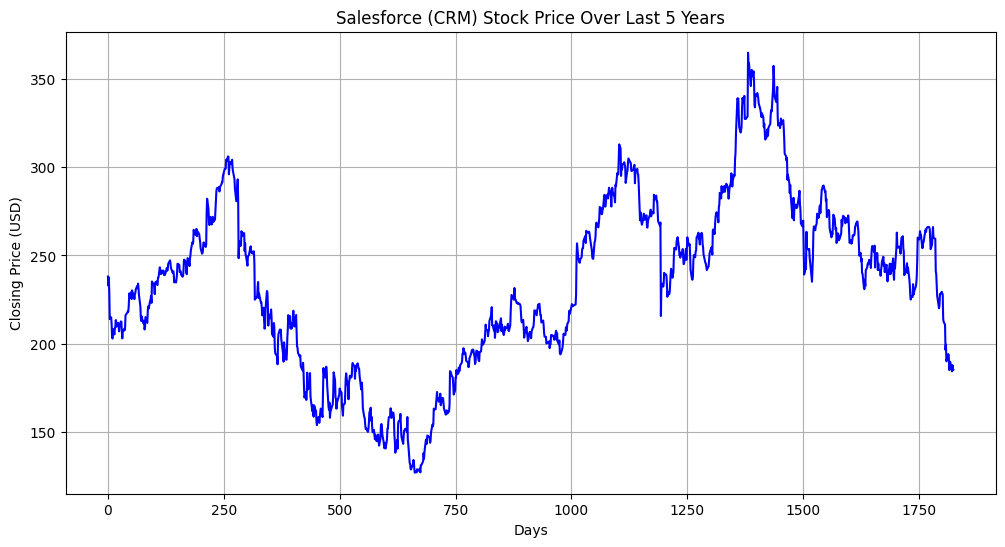

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data['Days'], data['Close'], color='blue')
plt.xlabel("Days")
plt.ylabel("Closing Price (USD)")
plt.title("Salesforce (CRM) Stock Price Over Last 5 Years")
plt.grid(True)
plt.show()

In [ ]:
# Prepare features and target
X = data[['Days']]  # Independent variable
y = data['Close']   # Dependent variable

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 2092.351184626282
R² Score: 0.17047564888332678


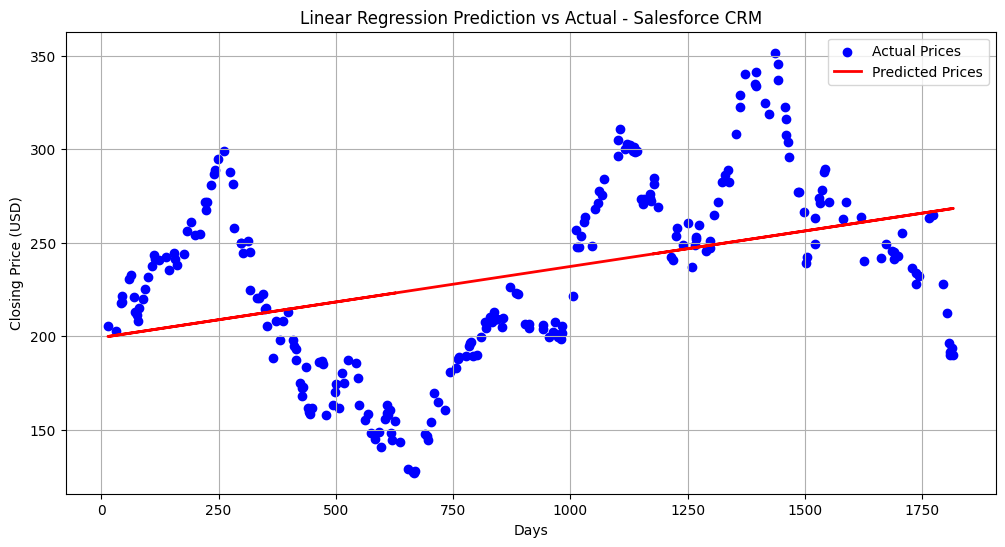

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(X_test, y_test, color='blue', label='Actual Prices')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted Prices')
plt.xlabel("Days")
plt.ylabel("Closing Price (USD)")
plt.title("Linear Regression Prediction vs Actual - Salesforce CRM")
plt.legend()
plt.grid(True)
plt.show()

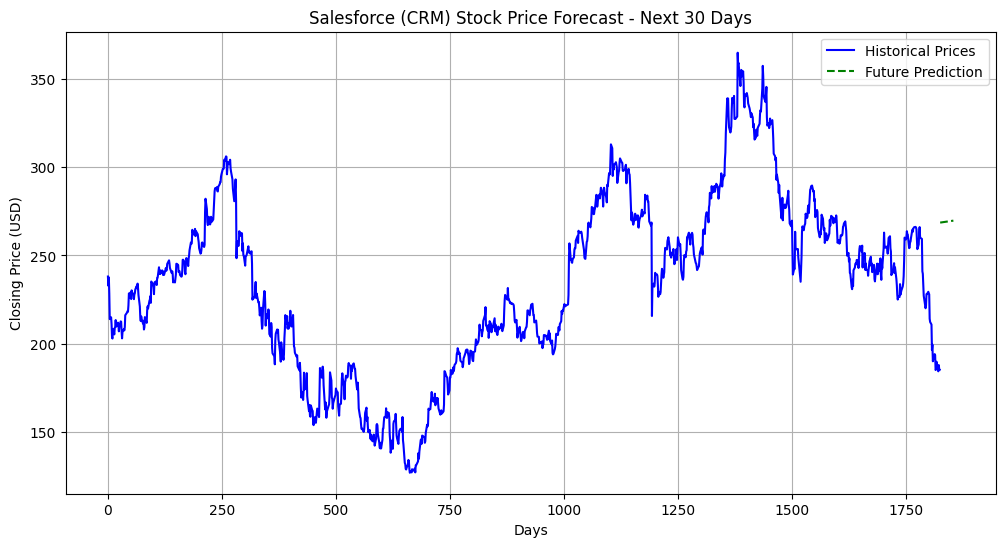

In [ ]:
# Prepare future days for prediction
future_days = np.array(range(data['Days'].max()+1, data['Days'].max()+31)).reshape(-1,1)

# Predict future closing prices
future_pred = model.predict(future_days)

# Plot historical + future predictions
plt.figure(figsize=(12,6))
plt.plot(data['Days'], data['Close'], color='blue', label='Historical Prices')
plt.plot(future_days, future_pred, color='green', linestyle='--', label='Future Prediction')
plt.xlabel("Days")
plt.ylabel("Closing Price (USD)")
plt.title("Salesforce (CRM) Stock Price Forecast - Next 30 Days")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Step 1: Re-download first date safely
first_date = pd.to_datetime(yf.download("CRM", period="5y").index[0])

# Step 2: Recreate Date column for historical data
data['Date'] = first_date + pd.to_timedelta(data['Days'], unit='D')

# Step 3: Prepare future dates
future_dates = pd.date_range(start=data['Date'].max() + pd.Timedelta(days=1), periods=30)

# Step 4: Flatten future_pred to 1D
future_pred_flat = future_pred.flatten()  # Important to remove 2D shape

# Step 5: Create future dataframe
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_pred_flat
})

# Step 6: Historical dataframe
historical_df = data.copy()
historical_df['Predicted_Close'] = np.nan
historical_df = historical_df[['Date','Close','Predicted_Close']]

# Step 7: Combine historical + future
combined_df = pd.concat([historical_df, future_df], ignore_index=True)

# Step 8: Export CSV
combined_df.to_csv("CRM_stock_forecast.csv", index=False)
print("CSV exported successfully!")

/tmp/ipython-input-3980440175.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  first_date = pd.to_datetime(yf.download("CRM", period="5y").index[0])
[*********************100%***********************]  1 of 1 completed

CSV exported successfully!


In [ ]:
from google.colab import files
files.download("CRM_stock_forecast.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>